### Edge Detection

Edge detection is an image processing technique that is used to identify the boundaries(edges) of objects or regions within an image. The underlying structure of an image through its edges.Sudden chnages in pixel intensity charecterize edges. Looking for such changes in the neighbouring pixels to detect edges. Canny Edge Detection and Sobel Edge Detection are two important edge detection algorithm.

#### Why to detect edges?

Detecting an edge plays very important role in various computer vision applications. Some of the purposes behind edge detection are,

    To create a line drawing of an image scene.
    To extract essential features of edges from an image (such as corners, curves, boundaries, lines, etc.).
    To generate features for various computer vision algorithms (such as object recognition)

In the above figure, the right image is produced by applying edge detection technique in the left image. You can see that we can still recognize the image on the right as a maze from its outlines.

Since there are continuous intensity changes along the edges, it will be easier to apply gradient methods along the edge to detect it. Hence, detecting an edge is preferred than interest points in these conditions.


### Canny Edge Detection 

Canny edge detection is one of the most popular edge-detectiion methods in use today because it is so robust and flexible. The algorithm follows four steps including Image smoothing for reducing noise.
1. Noise Reduction
2. Calculation of Intensity Gradient of the image
3. Suppresion of False Edges
4. Hysteresis Thresholding


In [1]:
# Imporing Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Plotting images
def plot_two_images(image, new_image,title1, title2):
    """
    Plot two Images

    Parameters
    ----------
    image:  Image or numpy.ndarray
        First Image to be plotted.
    new_image: a number or float or int 
        Second Image to be plotted.
    title1: text or string  
        Title for First Image
    title2: text or string
        Title for second Image
    """
    f, axes = plt.subplots(1, 2 , figsize=(10,8))
    axes[0].imshow(image,cmap='gray')
    axes[1].imshow(new_image,cmap='gray')
    plt.setp(axes[0], xlabel=title1)
    plt.setp(axes[1], xlabel=title2)
    f.tight_layout()
    plt.show()

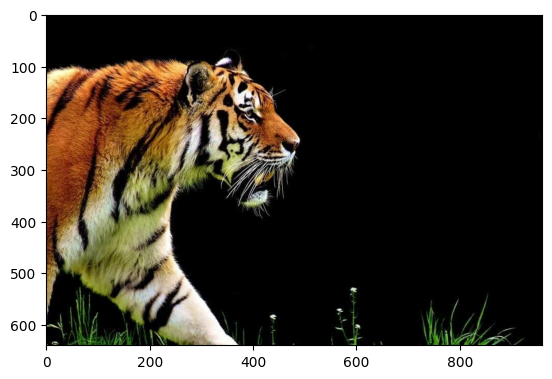

In [3]:
# Load images 
image_path = '../dataset/tiger.jpg'
image = cv2.imread(image_path)

# Display image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


##### Noise Reduction
Raw image pixels can lead to noisy edges so it is essential foe reduce noise before computing edges in Canny Edge Detection, a Gaussain blur is used to remov or minimize unnecessary detail tthat could lead to undesirable edges.

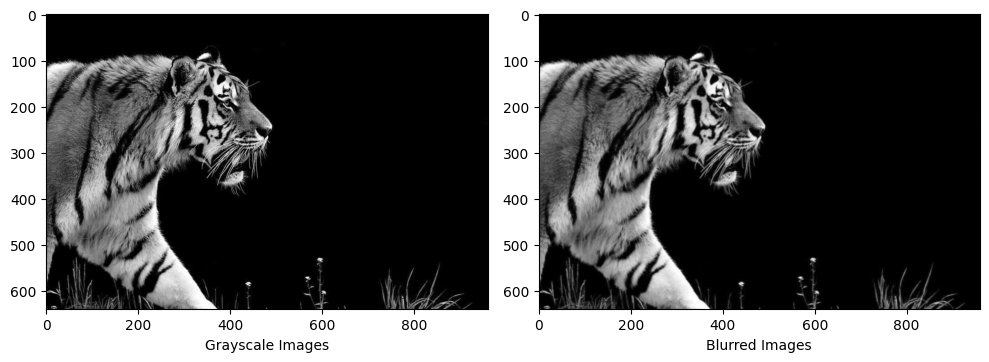

In [4]:
# change image to grayscale
image_gray =  cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blurred the image for reducing noise and better edge detection a
image_blur = cv2.GaussianBlur(image_gray, (3,3), 0) 

# plot images
plot_two_images(image = image_gray, new_image = image_blur,title1 ="Grayscale Images", title2 = "Blurred Images")

#### Calculating the intensity Gradient of the image
Once the image has been smoothed(blured and noise removed) it is filtered and result from these filtering operartions are used to calculate intensity gradient magnitude(G), and direction () for each pixel.

In [5]:
from scipy import ndimage
import numpy as np

def sobel_filters(img):
    # Sobel kernels for horizontal and vertical edge detection
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    # Convolve the image with the Sobel kernels to compute gradients
    Ix = ndimage.convolve(img, Kx)
    Iy = ndimage.convolve(img, Ky)

    # Compute the gradient magnitude
    G = np.hypot(Ix, Iy)
    
    # Normalize the gradient magnitude to the range [0, 255]
    G = G / G.max() * 255

    # Compute the gradient direction (in radians)
    theta = np.arctan2(Iy, Ix)

    return (G, theta)


In [6]:
gradient,theta = sobel_filters(image_blur)

In [7]:
gradient

array([[  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       ...,
       [ 43.8 ,  49.12, 177.4 , ...,   0.  ,   0.  ,   0.  ],
       [ 88.6 ,  98.3 , 145.6 , ...,   0.  ,   0.  ,   0.  ],
       [107.7 , 125.4 ,  87.5 , ...,   0.  ,   0.  ,   0.  ]],
      dtype=float16)

In [8]:
theta

array([[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [1.393 , 0.724 , 1.191 , ..., 0.    , 0.    , 0.    ],
       [1.499 , 0.9487, 0.2202, ..., 0.    , 0.    , 0.    ],
       [1.519 , 0.978 , 1.408 , ..., 0.    , 0.    , 0.    ]],
      dtype=float16)

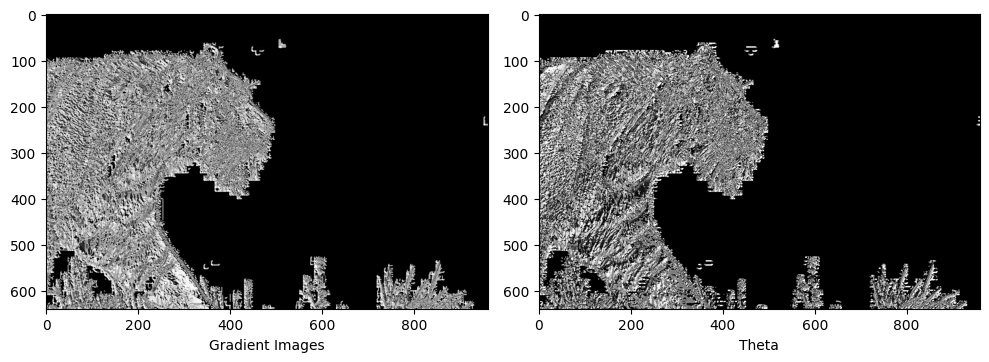

In [9]:
plot_two_images(gradient,theta,"Gradient Images","Theta")

#### Suppresion of False Edges
After reducing noise and calculating the intensiy gradient, the algorithm in this step uses a technique called non-maximum supression of edges to filter out unwanted pixels. Each pixel is compared to its neighboring pixels in the positive and negative gradient directions. If the gradient magnitude of the current pixel is greater than its neighbouring pixels, it is left unchanged Otherwise the magnitude of the current pixel is set to zero.

In [10]:
def non_max_suppression(img, D):
    """
    Apply non-maximum suppression to an edge magnitude image based on gradient directions.

    Parameters:
    - img (numpy.ndarray): The input edge magnitude image where edges are to be thinned.
    - D (numpy.ndarray): The gradient direction image in radians corresponding to 'img'.

    Returns:
    - numpy.ndarray: An image resulting from non-maximum suppression where only local maxima
      in edge magnitude are retained, and weaker edges are suppressed.

    """
    M, N = img.shape
    Z = np.zeros((M, N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, M - 1):
        for j in range(1, N - 1):
            try:
                q = 255
                r = 255

                # Angle 0
                if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                    q = img[i, j + 1]
                    r = img[i, j - 1]
                # Angle 45
                elif (22.5 <= angle[i, j] < 67.5):
                    q = img[i + 1, j - 1]
                    r = img[i - 1, j + 1]
                # Angle 90
                elif (67.5 <= angle[i, j] < 112.5):
                    q = img[i + 1, j]
                    r = img[i - 1, j]
                # Angle 135
                elif (112.5 <= angle[i, j] < 157.5):
                    q = img[i - 1, j - 1]
                    r = img[i + 1, j + 1]

                if (img[i, j] >= q) and (img[i, j] >= r):
                    Z[i, j] = img[i, j]
                else:
                    Z[i, j] = 0

            except IndexError as e:
                pass

    return Z


In [11]:
supression_images = non_max_suppression(gradient, theta)

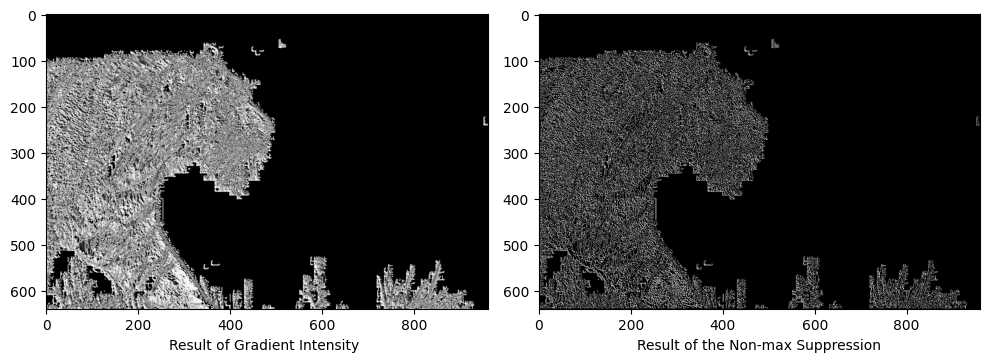

In [12]:
plot_two_images(gradient,supression_images,"Result of Gradient Intensity ","Result of the Non-max Suppression")

#### Hysteresis Thresholding – Edge Detection Using OpenCV

In this final step of Canny Edge Detection, the gradient magnitudes are compared with two threshold values, one smaller than the other. 

- If the gradient magnitude value is higher than the larger threshold value, those pixels are associated with solid edges and are included in the final edge map.
- If the gradient magnitude values are lower than the smaller threshold value, the pixels are suppressed and excluded from the final edge map.
- All the other pixels, whose gradient magnitudes fall between these two thresholds, are marked as ‘weak’ edges (i.e. they become candidates for being included in the final edge map). 
- If the ‘weak’ pixels are connected to those associated with solid edges, they are also included in the final edge map. 


In [13]:
# Canny Edge Detection
edges = cv2.Canny(image=image_blur, threshold1=100, threshold2=200) 

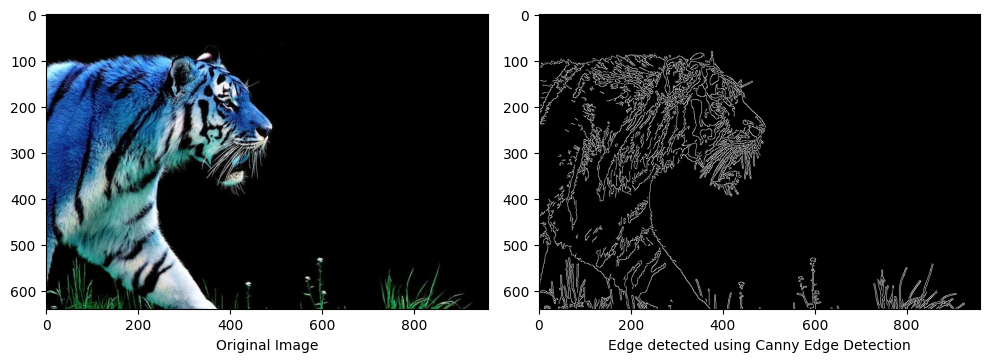

In [14]:
plot_two_images(image = image, new_image = edges, title1 = "Original Image",title2 ="Edge detected using Canny Edge Detection")

### Sobel Edge Detection

Sobel Edge Detection is a widely used method for detecting edges in digital images. It relies on convolution operations with two 3x3 kernels (one for detecting vertical edges and another for detecting horizontal edges) to compute the gradient of an image. The gradient magnitude and direction are then used to identify and highlight edges.

In [15]:
# Sobel Edge Detection
sobelx = cv2.Sobel(src=image_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
sobely = cv2.Sobel(src=image_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis
sobelxy = cv2.Sobel(src=image_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection

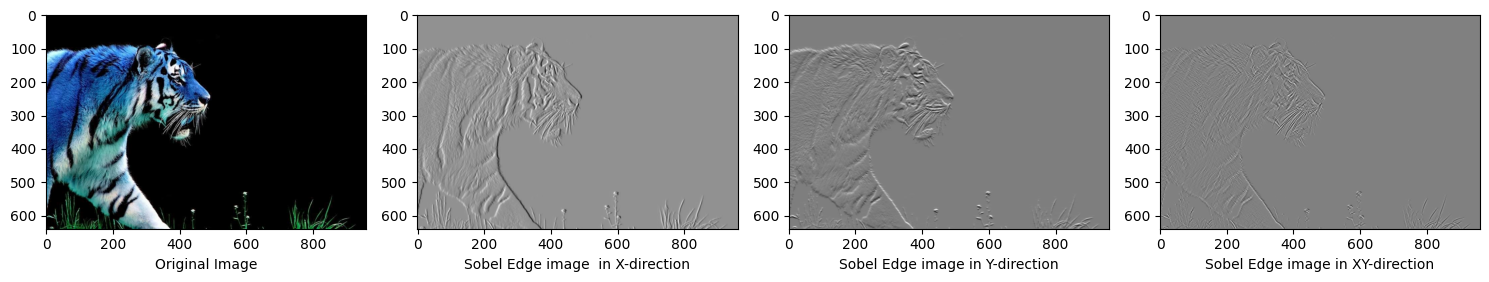

In [16]:
f, axes = plt.subplots(1, 4 , figsize=(15,8))
axes[0].imshow(image,cmap='gray')
axes[1].imshow(sobelx,cmap='gray')
axes[2].imshow(sobely,cmap='gray')
axes[3].imshow(sobelxy,cmap='gray')
plt.setp(axes[0], xlabel="Original Image")
plt.setp(axes[1], xlabel="Sobel Edge image  in X-direction")
plt.setp(axes[2], xlabel="Sobel Edge image in Y-direction")
plt.setp(axes[3], xlabel="Sobel Edge image in XY-direction")
f.tight_layout()
plt.show()